<a href="https://colab.research.google.com/github/karshingupta/Capstone3/blob/main/cleaning%2BEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import spacy
from spacy.language import Language

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import plotly.express as px

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

games = pd.read_csv('games.csv')

In [2]:
games

,Unnamed: 0,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist
0,0,Elden Ring,"Feb 25, 2022","['Bandai Namco Entertainment', 'FromSoftware']",4.5,3.9K,3.9K,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17K,3.8K,4.6K,4.8K
1,1,Hades,"Dec 10, 2019",['Supergiant Games'],4.3,2.9K,2.9K,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,['convinced this is a roguelike for people who...,21K,3.2K,6.3K,3.6K
2,2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",4.4,4.3K,4.3K,"['Adventure', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,['This game is the game (that is not CS:GO) th...,30K,2.5K,5K,2.6K
3,3,Undertale,"Sep 15, 2015","['tobyfox', '8-4']",4.2,3.5K,3.5K,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...","A small child falls into the Underground, wher...",['soundtrack is tied for #1 with nier automata...,28K,679,4.9K,1.8K
4,4,Hollow Knight,"Feb 24, 2017",['Team Cherry'],4.4,3K,3K,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible, with...",21K,2.4K,8.3K,2.3K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,1507,Back to the Future: The Game,"Dec 22, 2010",['Telltale Games'],3.2,94,94,"['Adventure', 'Point-and-Click']",Back to the Future: The Game is one of Telltal...,['Very enjoyable game. The story adds onto the...,763,5,223,67
1508,1508,Team Sonic Racing,"May 21, 2019","['Sumo Digital', 'Sega']",2.9,264,264,"['Arcade', 'Racing']",Team Sonic Racing combines the best elements o...,"['jogo morto mas bom', 'not my cup of tea', ""C...",1.5K,49,413,107
1509,1509,Dragon's Dogma,"May 22, 2012",['Capcom'],3.7,210,210,"['Brawler', 'RPG']","Set in a huge open world, Dragon’s Dogma: Dark...","['Underrated.', 'A grandes rasgos, es como un ...",1.1K,45,487,206
1510,1510,Baldur's Gate 3,"Oct 06, 2020",['Larian Studios'],4.1,165,165,"['Adventure', 'RPG', 'Strategy', 'Tactical', '...","An ancient evil has returned to Baldur's Gate,...",['Bu türe bu oyunla girmeye çalışmak hataydı s...,269,79,388,602


In [3]:
games.drop(['Number of Reviews'], axis=1, inplace=True)

In [4]:
games.set_index('Unnamed: 0', inplace=True)

In [5]:
games.rename_axis('GameID', inplace=True)

In [6]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1512 entries, 0 to 1511
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         1512 non-null   object 
 1   Release Date  1512 non-null   object 
 2   Team          1511 non-null   object 
 3   Rating        1499 non-null   float64
 4   Times Listed  1512 non-null   object 
 5   Genres        1512 non-null   object 
 6   Summary       1511 non-null   object 
 7   Reviews       1512 non-null   object 
 8   Plays         1512 non-null   object 
 9   Playing       1512 non-null   object 
 10  Backlogs      1512 non-null   object 
 11  Wishlist      1512 non-null   object 
dtypes: float64(1), object(11)
memory usage: 153.6+ KB


In [7]:
missing = pd.concat([games.isnull().sum(), 100 * games.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing = missing.sort_values(by='%', ascending=False)

In [8]:
missing

,count,%
Rating,13,0.859788
Team,1,0.066138
Summary,1,0.066138
Title,0,0.000000
Release Date,0,0.000000
Times Listed,0,0.000000
Genres,0,0.000000
Reviews,0,0.000000
Plays,0,0.000000
Playing,0,0.000000


Very few missing values, so I will drop the rows with nans.

In [9]:
games = games.dropna()

In [10]:
games.shape

(1498, 12)

In [11]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1498 entries, 0 to 1511
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         1498 non-null   object 
 1   Release Date  1498 non-null   object 
 2   Team          1498 non-null   object 
 3   Rating        1498 non-null   float64
 4   Times Listed  1498 non-null   object 
 5   Genres        1498 non-null   object 
 6   Summary       1498 non-null   object 
 7   Reviews       1498 non-null   object 
 8   Plays         1498 non-null   object 
 9   Playing       1498 non-null   object 
 10  Backlogs      1498 non-null   object 
 11  Wishlist      1498 non-null   object 
dtypes: float64(1), object(11)
memory usage: 152.1+ KB


Data type conversions to take place: <br>
* Release Date to datetime
* Times Listed to int
* Num Reviews to int
* Plays to int
* Playing to int
* Backlogs to int
* Wishlist to int



Deltarune released on Oct 31, 2018.

In [12]:
games.loc[644, 'Release Date'] = 'Oct 31, 2018'

Check for any more "releases on TBD" within the release dates.

In [13]:
releasetbd = games['Release Date'] == 'releases on TBD'

In [14]:
tbdgames = games[releasetbd]

In [15]:
tbdgames

,Title,Release Date,Team,Rating,Times Listed,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist
GameID,,,,,,,,,,,,
1252,Elden Ring: Shadow of the Erdtree,releases on TBD,"['FromSoftware', 'Bandai Namco Entertainment']",4.8,18,"['Adventure', 'RPG']",An expansion to Elden Ring setting players on ...,['I really loved that they integrated Family G...,1,0,39,146


In [16]:
games.loc[1252, 'Release Date'] = 'June 21, 2024'

In [17]:
from dateutil import parser
def parse_date(date_string):
    if pd.isna(date_string) or date_string == 'TBD':
        return pd.NaT
    try:
        return parser.parse(date_string)
    except:
        return pd.NaT
games['Release Date'] = games['Release Date'].apply(parse_date)

<ipython-input-17-b1372f6560ca>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games['Release Date'] = games['Release Date'].apply(parse_date)


Times Listed, Num Reviews, Plays, Playing, Backlogs, and Wishlist show 1,000 as "1k". Need a function which: <br>

* identify a k in the value
* strips the value of the k
* converts to int
* multiplies the value from 1,000
* if no k found, just convert to int



In [18]:
def convert_k_values(value):
    if isinstance(value, str):
        if 'k' in value.lower():
            return int(float(value.lower().replace('k', '')) * 1000)
        else:
            return int(float(value))
    else:
        return value

In [86]:
columns_to_convert = ['Times Listed', 'Plays', 'Playing', 'Backlogs', 'Wishlist']
games.update(games[columns_to_convert].map(convert_k_values))
for column in columns_to_convert:
    games[column] = games[column].astype(float).astype('Int64')

In [87]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1085 entries, 0 to 1511
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Title            1085 non-null   object        
 1   Release Date     1085 non-null   datetime64[ns]
 2   Team             1085 non-null   object        
 3   Rating           1085 non-null   float64       
 4   Times Listed     1085 non-null   Int64         
 5   Genres           1085 non-null   object        
 6   Summary          1085 non-null   object        
 7   Reviews          1085 non-null   object        
 8   Plays            1085 non-null   Int64         
 9   Playing          1085 non-null   Int64         
 10  Backlogs         1085 non-null   Int64         
 11  Wishlist         1085 non-null   Int64         
 12  Genre_Weight     1085 non-null   float32       
 13  Team_Cluster     1085 non-null   int32         
 14  Summary_Cluster  1085 non-null   int32       

In [21]:
games.head(10)

,Title,Release Date,Team,Rating,Times Listed,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist
GameID,,,,,,,,,,,,
0,Elden Ring,2022-02-25,"['Bandai Namco Entertainment', 'FromSoftware']",4.5,3900,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17000,3800,4600,4800
1,Hades,2019-12-10,['Supergiant Games'],4.3,2900,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,['convinced this is a roguelike for people who...,21000,3200,6300,3600
2,The Legend of Zelda: Breath of the Wild,2017-03-03,"['Nintendo', 'Nintendo EPD Production Group No...",4.4,4300,"['Adventure', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,['This game is the game (that is not CS:GO) th...,30000,2500,5000,2600
3,Undertale,2015-09-15,"['tobyfox', '8-4']",4.2,3500,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...","A small child falls into the Underground, wher...",['soundtrack is tied for #1 with nier automata...,28000,679,4900,1800
4,Hollow Knight,2017-02-24,['Team Cherry'],4.4,3000,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible, with...",21000,2400,8300,2300
5,Minecraft,2011-11-18,['Mojang Studios'],4.3,2300,"['Adventure', 'Simulator']",Minecraft focuses on allowing the player to ex...,['Minecraft is what you make of it. Unfortunat...,33000,1800,1100,230
6,Omori,2020-12-25,"['OMOCAT', 'PLAYISM']",4.2,1600,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...",A turn-based surreal horror RPG in which a chi...,"[""The best game I've played in my life"", ""omor...",7200,1100,4500,3800
7,Metroid Dread,2021-10-07,"['Nintendo', 'MercurySteam']",4.3,2100,"['Adventure', 'Platform']",Join intergalactic bounty hunter Samus Aran in...,['Have only been a Metroid fan for couple of y...,9200,759,3400,3300
8,Among Us,2018-06-15,['InnerSloth'],3.0,867,"['Indie', 'Strategy']",Join your crew-mates in a multiplayer game of ...,"[""it's a solid party game. i'm bad at lying th...",25000,470,776,126


In [22]:
games.isnull().sum()

,0
Title,0
Release Date,0
Team,0
Rating,0
Times Listed,0
Genres,0
Summary,0
Reviews,0
Plays,0
Playing,0


In [23]:
games.describe()

,Release Date,Rating
count,1498,1498.000000
mean,2012-08-17 07:56:47.743658240,3.720027
min,1980-05-22 00:00:00,0.700000
25%,2007-09-13 06:00:00,3.400000
50%,2014-07-26 00:00:00,3.800000
75%,2019-08-28 12:00:00,4.100000
max,2024-06-21 00:00:00,4.800000
std,NaN,0.532133


Let's begin by looking at the textual data - Title, Team, Genres, Summary, and Reviews.

In [24]:
games['Title']

,Title
GameID,
0,Elden Ring
1,Hades
2,The Legend of Zelda: Breath of the Wild
3,Undertale
4,Hollow Knight
...,...
1507,Back to the Future: The Game
1508,Team Sonic Racing
1509,Dragon's Dogma


In [25]:
games = games.drop_duplicates(subset='Title')

In [26]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1085 entries, 0 to 1511
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Title         1085 non-null   object        
 1   Release Date  1085 non-null   datetime64[ns]
 2   Team          1085 non-null   object        
 3   Rating        1085 non-null   float64       
 4   Times Listed  1085 non-null   object        
 5   Genres        1085 non-null   object        
 6   Summary       1085 non-null   object        
 7   Reviews       1085 non-null   object        
 8   Plays         1085 non-null   object        
 9   Playing       1085 non-null   object        
 10  Backlogs      1085 non-null   object        
 11  Wishlist      1085 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 110.2+ KB


Basic cleaning involved dropping 15 missing values (13 ratings, 1 team, 1 summary). < 1 % of data removed, so no integrity loss. Release date was converted to datetime. The other numerical values were converted to ints. To ensure only unique games are included in the set, I drop duplicates based on the Title column. This reduces the number of rows from 1,512 to 1,085.


In [27]:
titles = games['Title'].tolist()
titles = [title.replace(' ', '_') for title in titles]

max_tokens = 10000
output_mode = 'tf_idf'
ngrams = 1

vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode=output_mode,
    ngrams=ngrams
)

vectorize_layer.adapt(titles)

model = tf.keras.Sequential([
    vectorize_layer
])

titles_tensor = tf.constant(titles)

tfidf_vectors = model.predict(titles_tensor)

vocab = vectorize_layer.get_vocabulary()
aggregate_weights = np.sum(tfidf_vectors, axis=0)
token_weight_pairs = [(token, weight) for token, weight in zip(vocab, aggregate_weights) if weight > 0]

sorted_tokens_weights = sorted(token_weight_pairs, key=lambda x: x[1], reverse=True)

unique_weights = set(weight for _, weight in sorted_tokens_weights)

sorted_unique_weights = sorted(unique_weights, reverse=True)

print("Unique weights:")
for weight in sorted_unique_weights:
    print(f"{weight:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Unique weights:
11.7870
6.2980


In [28]:
N = 5
print(f"\nTop {N} token weights:")
for token, weight in sorted_tokens_weights[:N]:
    print(f"{token}: {weight:.4f}")


Top 5 token weights:
starwarsbattlefrontii: 11.7870
Ōkamihd: 6.2980
zeroranger: 6.2980
zeroescapezerotimedilemma: 6.2980
zeroescapeninehoursninepersonsninedoors: 6.2980


In [29]:
sw = games['Title'].str.contains('Star Wars')

In [30]:
swdf = games[sw]

In [31]:
swdf

,Title,Release Date,Team,Rating,Times Listed,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist
GameID,,,,,,,,,,,,
77,Star Wars Jedi: Fallen Order,2019-11-15,"['Respawn Entertainment', 'Electronic Arts']",3.7,1400,['Adventure'],Star Wars Jedi: Fallen Order is a narratively ...,"['I dropped this originally, went back and had...",13000,740,3700,1300
271,Star Wars: Knights of the Old Republic,2003-07-15,"['BioWare', 'LucasArts']",4.2,839,"['Adventure', 'RPG']","Choose Your Path! Set 4,000 years before the G...",['I get why a lot of people love this game but...,5300,180,2300,705
595,Star Wars: The Force Unleashed,2008-09-16,"['THQ Wireless', 'Aspyr Media']",3.2,417,"['Adventure', 'Brawler', 'RPG']",Star Wars: The Force Unleashed is a Star Wars ...,"['okay!', 'Really makes you\n ...",7400,50,823,350
775,Star Wars: The Force Unleashed II,2010-10-26,['LucasArts'],2.8,242,"['Adventure', 'Brawler', 'RPG']",The Star Wars Saga continues with Star Wars: T...,"[""Better graphics and gameplay than the origin...",4100,18,597,268
1088,Star Wars Battlefront II,2017-11-17,"['EA Digital Illusions CE', 'Electronic Arts']",3.1,534,"['Adventure', 'Shooter']",Embark on an endless Star Wars action experien...,['i forgot i played this game until i saw a fr...,7800,128,826,140
1092,Star Wars: Battlefront II,2005-10-31,"['Pandemic Studios', 'LucasArts']",4.0,650,['Shooter'],Star Wars: Battlefront II is the sequel to Sta...,['There is actually zero depth to anything in ...,7700,35,520,189
1303,Star Wars: Battlefront,2004-09-20,"['Pandemic Studios', 'LucasArts']",3.5,255,['Shooter'],Star Wars: Battlefront is the first in the Sta...,['Not as fun as battlefront 2 due to missing h...,4100,9,261,109
1357,Star Wars: Episode III - Revenge of the Sith,2005-05-05,"['LucasArts', 'The Collective']",3.1,141,"['Adventure', 'Brawler']","Third-person action/adventure game, Star Wars:...",['Pretty good game. I like the force powers an...,2100,11,167,94


In [32]:
games.loc[1088, 'Title'] = 'EA Star Wars Battlefront II'

In [33]:
titles = games['Title'].tolist()
titles = [title.replace(' ', '_') for title in titles]

max_tokens = 10000
output_mode = 'tf_idf'
ngrams = 1

vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode=output_mode,
    ngrams=ngrams
)

vectorize_layer.adapt(titles)

model = tf.keras.Sequential([
    vectorize_layer
])

titles_tensor = tf.constant(titles)

tfidf_vectors = model.predict(titles_tensor)

vocab = vectorize_layer.get_vocabulary()
aggregate_weights = np.sum(tfidf_vectors, axis=0)
token_weight_pairs = [(token, weight) for token, weight in zip(vocab, aggregate_weights) if weight > 0]

sorted_tokens_weights = sorted(token_weight_pairs, key=lambda x: x[1], reverse=True)

unique_weights = set(weight for _, weight in sorted_tokens_weights)

sorted_unique_weights = sorted(unique_weights, reverse=True)

print("Unique weights:")
for weight in sorted_unique_weights:
    print(f"{weight:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Unique weights:
6.2980


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


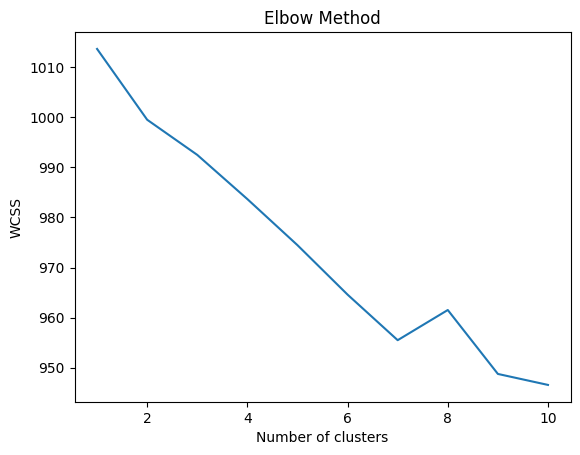

In [34]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(games['Title'].tolist())

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [35]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

clusters = kmeans.labels_

df = pd.DataFrame({'Title': titles, 'Cluster': clusters})

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

df_tsne = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
df_tsne['Cluster'] = clusters
df_tsne['Title'] = titles

fig = px.scatter(df_tsne, x='Dim1', y='Dim2', color='Cluster', hover_data=['Title'],
                 title="Game Title Clusters", labels={'Dim1': 'Dimension 1', 'Dim2': 'Dimension 2'})
fig.show()

As a baseline for the title, I used full string tokenization with TF-IDF for weights. I expected unique titles after removing duplicates and whitespaces before vectorizing with TF-IDF. However, I found weights [11.7, 6.2] instead of a single weight.

The 11.7 weight corresponded to "Star Wars Battlefront 2", which appeared twice:
"Star Wars: Battlefront 2" (2005)
"Star Wars Battlefront 2" (2017)

Colons were removed during tokenization, making these titles identical.

To resolve this, I renamed the 2017 release to "EA Star Wars Battlefront 2". After this change and re-running tokenization, all titles had an equal weight of 6.2, confirming uniqueness in the set.

With titles now fully unique, I use text clustering with k-means to group similar titles together. I use the elbow method to decide on 8 as an optimal number of clusters. After plotting the clusters, there are no clear distinctions to be made. Franchises with multiple games of the same brand are grouped together.


The franchises with enough weight in the set to be made their own clusters are

Pokemon
Assassin's Creed
Mario
Sonic

These are all popular franchises with multiple entries to their name. I will only use the title as an identifier, and will not use it as a predictive feature.


In [36]:
all_genres = []
for genre_string in games['Genres']:
    genre_list = ast.literal_eval(genre_string)
    all_genres.extend(genre_list)

In [37]:
genres = set(all_genres)

In [38]:
def clean_genre_list(genre_list):
    cleaned = re.sub(r'[\[\]\'"]', '', genre_list).strip()
    genres = sorted([g.strip() for g in cleaned.split(',')])
    return ' '.join(genres)

genres = games['Genres'].tolist()
cleaned_genres = [clean_genre_list(genre) for genre in genres]

max_tokens = 10000
output_mode = 'tf_idf'

vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode=output_mode,
    ngrams=None,
    standardize='lower_and_strip_punctuation'
)

vectorize_layer.adapt(cleaned_genres)

model = tf.keras.Sequential([vectorize_layer])

genres_tensor = tf.constant(cleaned_genres)

tfidf_vectors = model.predict(genres_tensor)

unique_combinations = list(set(cleaned_genres))
combination_weights = {}

for combo in unique_combinations:
    indices = [i for i, x in enumerate(cleaned_genres) if x == combo]
    weight = np.sum(tfidf_vectors[indices])
    combination_weights[combo] = weight

sorted_combinations = sorted(combination_weights.items(), key=lambda x: x[1], reverse=True)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [39]:
games['Genres'] = cleaned_genres
games['Genre_Weight'] = games['Genres'].apply(lambda genre: combination_weights.get(genre, 0))

There are 23 total unique genres within the set, creating a total of 254 genre combinations. Each game can have more than one genre listed, such as [‘Adventure’, ‘RPG’, ‘Shooter’]. To find the most prevalent genre combinations, I use keyword extraction with Tf - Idf. I avoid clustering here as genres are relatively simplistic in comparison to the other textual data, and want to provide more granularity.

In [40]:
games

,Title,Release Date,Team,Rating,Times Listed,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist,Genre_Weight
GameID,,,,,,,,,,,,,
0,Elden Ring,2022-02-25,"['Bandai Namco Entertainment', 'FromSoftware']",4.5,3900,Adventure RPG,"Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17000,3800,4600,4800,218.852570
1,Hades,2019-12-10,['Supergiant Games'],4.3,2900,Adventure Brawler Indie RPG,A rogue-lite hack and slash dungeon crawler in...,['convinced this is a roguelike for people who...,21000,3200,6300,3600,26.383694
2,The Legend of Zelda: Breath of the Wild,2017-03-03,"['Nintendo', 'Nintendo EPD Production Group No...",4.4,4300,Adventure RPG,The Legend of Zelda: Breath of the Wild is the...,['This game is the game (that is not CS:GO) th...,30000,2500,5000,2600,218.852570
3,Undertale,2015-09-15,"['tobyfox', '8-4']",4.2,3500,Adventure Indie RPG Turn Based Strategy,"A small child falls into the Underground, wher...",['soundtrack is tied for #1 with nier automata...,28000,679,4900,1800,82.538727
4,Hollow Knight,2017-02-24,['Team Cherry'],4.4,3000,Adventure Indie Platform,A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible, with...",21000,2400,8300,2300,80.642258
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,Back to the Future: The Game,2010-12-22,['Telltale Games'],3.2,94,Adventure Point-and-Click,Back to the Future: The Game is one of Telltal...,['Very enjoyable game. The story adds onto the...,763,5,223,67,17.368029
1508,Team Sonic Racing,2019-05-21,"['Sumo Digital', 'Sega']",2.9,264,Arcade Racing,Team Sonic Racing combines the best elements o...,"['jogo morto mas bom', 'not my cup of tea', ""C...",1500,49,413,107,38.009930
1509,Dragon's Dogma,2012-05-22,['Capcom'],3.7,210,Brawler RPG,"Set in a huge open world, Dragon’s Dogma: Dark...","['Underrated.', 'A grandes rasgos, es como un ...",1100,45,487,206,26.842472


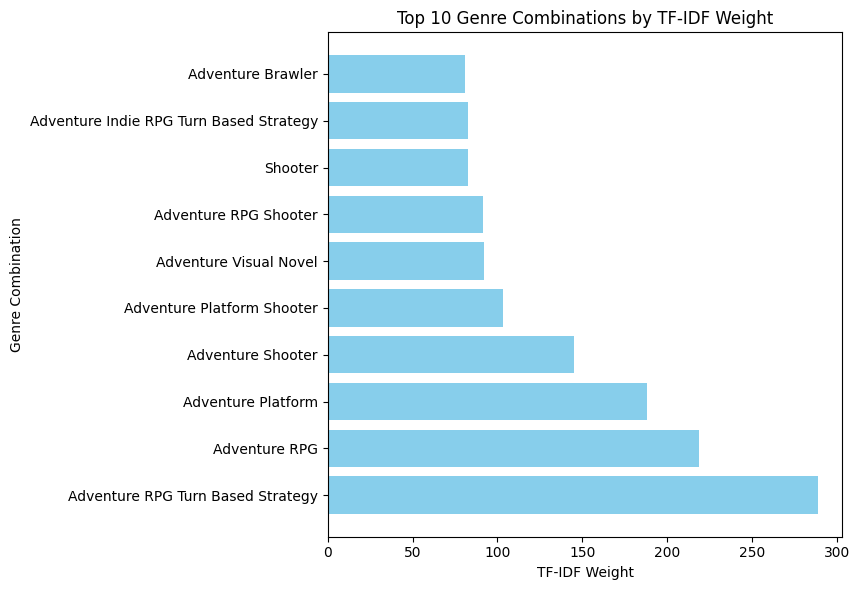

In [41]:
top_combos = [combo for combo, weight in sorted_combinations[:10]]
top_weights = [weight for combo, weight in sorted_combinations[:10]]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.barh(top_combos, top_weights, color='skyblue')
plt.xlabel('TF-IDF Weight')
plt.ylabel('Genre Combination')
plt.title('Top 10 Genre Combinations by TF-IDF Weight')

plt.tight_layout()
plt.show()

It is clear being an adventure game is favored in this dataset, as 9 of the top 10 genres have adventure within their combination. I assign each game a new feature, called Genre_Weight, which is the relevant genre combination weighted score.

In [42]:
all_teams = []
for team_string in games['Team']:
    team_list = ast.literal_eval(team_string)
    all_teams.extend(team_list)

In [43]:
teams = set(all_teams)

In [44]:
len(teams)

655

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


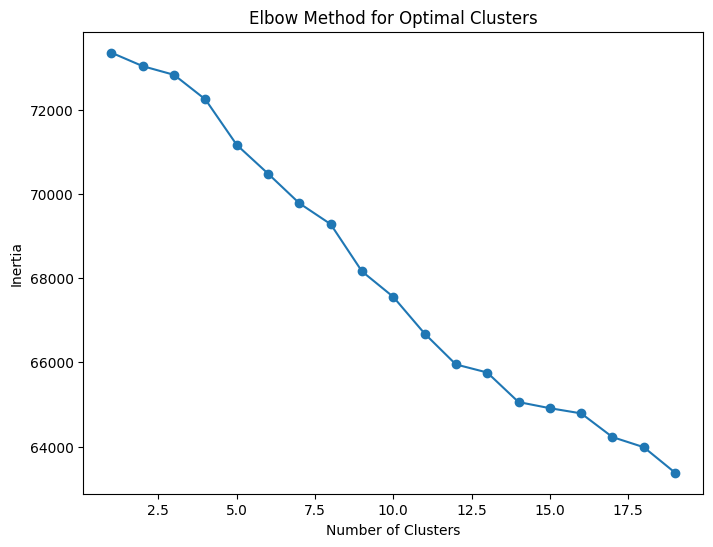

In [45]:
def clean_team_list(team):
    team = re.sub(r'[^\w\s]', '', team)
    return team

teams = games['Team'].tolist()
cleaned_teams = [clean_team_list(team) for team in teams]

max_tokens = 10000
output_mode = 'tf_idf'

vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode=output_mode,
    ngrams=None,
    standardize='lower_and_strip_punctuation'
)

vectorize_layer.adapt(cleaned_teams)

model = tf.keras.Sequential([vectorize_layer])

teams_tensor = tf.constant(cleaned_teams)
tfidf_vectors = model.predict(teams_tensor)

inertia = []
cluster_range = range(1, 20)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init = 'auto')
    kmeans.fit(tfidf_vectors)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

In [46]:
optimal_num_clusters = 20

kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42, n_init=10)  # Explicitly set n_init
kmeans.fit(tfidf_vectors)

clusters = kmeans.labels_

pca = PCA(n_components=2)
tfidf_vectors_2d = pca.fit_transform(tfidf_vectors)

df = pd.DataFrame(tfidf_vectors_2d, columns=['PC1', 'PC2'])
df['Cluster'] = clusters
df['Team'] = cleaned_teams

fig = px.scatter(df, x='PC1', y='PC2', color='Cluster', hover_data=['Team'],
                 title="Team Combinations Clusters",
                 labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2'})
fig.update_layout(legend_title="Cluster")
fig.show()


There are 655 unique teams in the set. Same as genres, they appear as combinations for each respective game, such as [‘EA’, 2k Games’].

I tokenize each set of teams into a single string for each game [‘EA’, ‘2k Games’] → EA 2k Games and use k-means clustering again to visualize any patterns. I use 20 clusters as a baseline, and can change this value later if I want to.

Nintendo (right), Capcom (bottom right), Ubisoft (top left), and Sony (bottom left), and all have their own respective branches. In the center of the graph is where we find our more independent and smaller game studios. I assign each game its respective team cluster under Team_Cluster.

In [47]:
games['Team_Cluster'] = kmeans.labels_

In [48]:
games['Summary'].tolist()

['Elden Ring is a fantasy, action and open world game with RPG elements such as stats, weapons and spells. Rise, Tarnished, and be guided by grace to brandish the power of the Elden Ring and become an Elden Lord in the Lands Between.',
 'A rogue-lite hack and slash dungeon crawler in which Zagreus, son of Hades the Greek god of the dead, attempts to escape his home and his oppressive father by fighting the souls of the dead through the various layers of the ever-shifting underworld, while getting to know and forging relationships with its inhabitants.',
 'The Legend of Zelda: Breath of the Wild is the first 3D open-world game in the Zelda series. Link can travel anywhere and be equipped with weapons and armor found throughout the world to grant him various bonuses. Unlike many games in the series, Breath of the Wild does not impose a specific order in which quests or dungeons must be completed. While the game still has environmental obstacles such as weather effects, inhospitable lands

The game summaries provide insights into a game in a short text format. I start by finding an ideal number of clusters to use based on inertia value.

I decide on 20 clusters to capture as many patterns in the summaries as possible. From looking at the titles, I know some clusters will be entirely dedicated to the more popular franchise. To work around this, I identify the most frequent words within the summaries and add them as custom stopwords.

In [49]:
games

,Title,Release Date,Team,Rating,Times Listed,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist,Genre_Weight,Team_Cluster
GameID,,,,,,,,,,,,,,
0,Elden Ring,2022-02-25,"['Bandai Namco Entertainment', 'FromSoftware']",4.5,3900,Adventure RPG,"Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17000,3800,4600,4800,218.852570,8
1,Hades,2019-12-10,['Supergiant Games'],4.3,2900,Adventure Brawler Indie RPG,A rogue-lite hack and slash dungeon crawler in...,['convinced this is a roguelike for people who...,21000,3200,6300,3600,26.383694,8
2,The Legend of Zelda: Breath of the Wild,2017-03-03,"['Nintendo', 'Nintendo EPD Production Group No...",4.4,4300,Adventure RPG,The Legend of Zelda: Breath of the Wild is the...,['This game is the game (that is not CS:GO) th...,30000,2500,5000,2600,218.852570,0
3,Undertale,2015-09-15,"['tobyfox', '8-4']",4.2,3500,Adventure Indie RPG Turn Based Strategy,"A small child falls into the Underground, wher...",['soundtrack is tied for #1 with nier automata...,28000,679,4900,1800,82.538727,6
4,Hollow Knight,2017-02-24,['Team Cherry'],4.4,3000,Adventure Indie Platform,A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible, with...",21000,2400,8300,2300,80.642258,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,Back to the Future: The Game,2010-12-22,['Telltale Games'],3.2,94,Adventure Point-and-Click,Back to the Future: The Game is one of Telltal...,['Very enjoyable game. The story adds onto the...,763,5,223,67,17.368029,8
1508,Team Sonic Racing,2019-05-21,"['Sumo Digital', 'Sega']",2.9,264,Arcade Racing,Team Sonic Racing combines the best elements o...,"['jogo morto mas bom', 'not my cup of tea', ""C...",1500,49,413,107,38.009930,6
1509,Dragon's Dogma,2012-05-22,['Capcom'],3.7,210,Brawler RPG,"Set in a huge open world, Dragon’s Dogma: Dark...","['Underrated.', 'A grandes rasgos, es como un ...",1100,45,487,206,26.842472,6


In [50]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import plotly.graph_objs as go

data = games['Summary'].tolist()

data = [str(item) for item in data if item is not None]

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(data)

X_normalized = normalize(X)

def kmeans_clustering(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    return kmeans.inertia_

max_clusters = 20
inertias = []

for k in range(2, max_clusters + 1):
    inertia = kmeans_clustering(X_normalized, k)
    inertias.append(inertia)

fig = go.Figure(data=go.Scatter(
    x=list(range(2, max_clusters + 1)),
    y=inertias,
    mode='lines+markers'
))

fig.update_layout(
    title='Elbow Method for Optimal k',
    xaxis_title='Number of clusters',
    yaxis_title='Inertia',
    showlegend=False
)

fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [51]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

data = games['Summary'].tolist()

data = [str(item) for item in data if item is not None]

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

custom_stop_words = ['game', 'player', 'players', 'gameplay', 'play', 'playing', 'played', 'character', 'characters', 'level', 'levels', 'story', 'world', 'new', 'feature', 'features', 'mode', 'modes', 'series', 'time']

all_stop_words = stop_words.union(custom_stop_words)

def preprocess(text):
    tokens = word_tokenize(text.lower())
    return [token for token in tokens if token.isalpha() and token not in all_stop_words]

processed_words = [word for summary in data for word in preprocess(summary)]

word_freq = Counter(processed_words)

top_words = word_freq.most_common(50)

df_top_words = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

all_stop_words = all_stop_words.union(set(df_top_words['Word']))

print("Top words added to stop words:")
print(', '.join(df_top_words['Word']))

vectorizer = TfidfVectorizer(stop_words=list(all_stop_words), max_features=1000)
X = vectorizer.fit_transform(data)

X_normalized = normalize(X)

n_clusters = 20

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_normalized)

games['Summary_Cluster'] = labels

def get_top_words(vectorizer, kmeans, n_words=10):
    feature_names = vectorizer.get_feature_names_out()
    top_words = {}
    for i in range(kmeans.n_clusters):
        center = kmeans.cluster_centers_[i]
        top_indices = center.argsort()[-n_words:][::-1]
        top_words[i] = [feature_names[ind] for ind in top_indices]
    return top_words

top_words = get_top_words(vectorizer, kmeans)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized.toarray())

colors = [f'rgb({np.random.randint(0,255)}, {np.random.randint(0,255)}, {np.random.randint(0,255)})' for _ in range(n_clusters)]

traces = []
for i in range(n_clusters):
    cluster_points = X_pca[labels == i]
    traces.append(go.Scatter(
        x=cluster_points[:, 0],
        y=cluster_points[:, 1],
        mode='markers',
        name=f'Cluster {i}',
        marker=dict(color=colors[i]),
        text=[f"Cluster: {i}<br>Top words: {', '.join(top_words[i])}" for _ in range(len(cluster_points))],
        hoverinfo='text'
    ))

layout = go.Layout(
    title='K-means Clustering of Game Summaries (20 Clusters)',
    xaxis=dict(title='First Principal Component'),
    yaxis=dict(title='Second Principal Component'),
    hovermode='closest'
)

fig = go.Figure(data=traces, layout=layout)
fig.show()

print("\nTop words for each cluster:")
for cluster, words in top_words.items():
    print(f"Cluster {cluster}: {', '.join(words)}")


Top words added to stop words:
games, adventure, first, also, one, experience, action, battle, mario, must, two, enemies, pokémon, set, take, original, combat, use, weapons, different, version, way, system, like, super, released, explore, fight, unique, well, evil, video, abilities, three, sonic, nintendo, friends, life, many, find, power, sequel, final, get, developed, make, save, around, back, elements



Top words for each cluster:
Cluster 0: man, person, 3d, third, mega, main, fighting, shooter, takes, known
Cluster 1: black, half, assassin, white, creed, journey, co, person, ops, begins
Cluster 2: cry, devil, may, dante, style, far, novel, second, dynamic, information
Cluster 3: planet, kirby, metroid, people, samus, future, fate, space, alien, choose
Cluster 4: fantasy, open, epic, rpg, remake, dark, japan, magic, remaster, graphics
Cluster 5: puzzles, puzzle, solve, solving, challenges, ds, professor, escape, based, zero
Cluster 6: island, battles, fast, paced, fun, kombat, king, wii, mortal, team
Cluster 7: emblem, fire, based, rpg, tactical, war, turn, god, kratos, squad
Cluster 8: star, duty, wars, warfare, call, force, modern, battlefield, ii, ops
Cluster 9: dark, monster, monsters, deadly, another, journey, twisted, mind, human, master
Cluster 10: family, kong, girl, hand, together, ancient, little, young, become, discover
Cluster 11: dragon, nier, content, ball, apocalyptic,

I really like some of these clusters, there are some clear takeaways here.

0 points to fighting.
4 points to Japanese open world.
8 points to war based.
9 points to monsters.
12 points to platformers.
13 points to survival horror.
14 points to racing.

I assign each game its cluster value as Summary_Cluster.


In [52]:
(games[['Title', 'Summary', 'Summary_Cluster']].head())

,Title,Summary,Summary_Cluster
GameID,,,
0,Elden Ring,"Elden Ring is a fantasy, action and open world...",4
1,Hades,A rogue-lite hack and slash dungeon crawler in...,0
2,The Legend of Zelda: Breath of the Wild,The Legend of Zelda: Breath of the Wild is the...,16
3,Undertale,"A small child falls into the Underground, wher...",5
4,Hollow Knight,A 2D metroidvania with an emphasis on close co...,0


In [53]:
print("\nCluster distribution:")
print(games['Summary_Cluster'].value_counts().sort_index())


Cluster distribution:
Summary_Cluster
0     267
1      40
2      17
3      64
4      33
5      47
6      64
7      69
8      23
9      99
10     79
11     38
12     13
13     46
14     46
15     19
16     23
17     28
18     52
19     18
Name: count, dtype: int64


In [54]:
pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 41.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=aba38b80478d31c31cd699f7b97e93012ae6ae165e007a1e6216015fc435cb9f
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


Reviews are the most unstructured feature within the textual data. I start with tokenization and cleaning. Reviews per game are separated through outer square brackets []. Each game can have multiple reviews, these are separated by slashes \. Use of \\n to denote newlines, needs to be removed.

Additionally, I use langdetect to find a total of 7 unique languages, with the majority being in English (1024 reviews), followed by Portuguese (50 reviews), and Spanish (9 reviews).

With a multilingual presence, I use distiluse-base-multilingual-cased-v from SBert to create embeddings for each review. These embeddings are then stored as ‘Embeddings’ for each game.


In [55]:
import pandas as pd
from langdetect import detect, DetectorFactory
from collections import defaultdict

DetectorFactory.seed = 0

language_counts = defaultdict(int)

all_languages = []

for review_corpus in games['Reviews']:
    review_corpus = review_corpus.strip('[]')
    reviews = review_corpus.split(' / ')

    for review in reviews:
        try:
            lang = detect(review)
            language_counts[lang] += 1
            all_languages.append(lang)
        except:
            all_languages.append('unknown')
            continue

language_df = pd.DataFrame(list(language_counts.items()), columns=['Language', 'Number of Reviews'])

print("Languages detected in the reviews:")
print(language_df)

Languages detected in the reviews:
  Language  Number of Reviews
0       en               1024
1       pt                 50
2       tr                  1
3       et                  1
4       it                  3
5       es                  9
6       ru                  1


In [57]:
from sentence_transformers import SentenceTransformer

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



In [66]:
games['Reviews'] = games['Reviews'].apply(lambda x: x.replace('\\', '').replace('\n', '').replace('\'', '').replace(',', ''))

In [67]:
games['Reviews'].tolist()

['["The first playthrough of elden ring is one of the best eperiences gaming can offer you but after youve explored everything in the open world and youve experienced all of the surprises you lose motivation to go exploring on repeat playthroughs which takes a lot away from the replayability which is a very important thing for from games imo." a replay solidified my love for elden ring. so easily my favorite game of all time. actually beating malenia this time was also an amazing feeling. i just love being in this world man its the greatest of all time The game is absolutely beautiful with so much to do. The replayability is crazy. And it never gets old with it too. Took everything great about the Soulsborne games and make it 100% better. I play with my overlevelled friend every time and we still fail sometimes (he’s on NG6) insanely difficult game loln                     n                     gorgeous graphics animations everything about this game is so beautiful. deserves all the hy

In [73]:
from sentence_transformers import SentenceTransformer
import ast

model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v1')

def safe_eval(s):
    try:
        return ast.literal_eval(s)
    except:
        return [s]

review_corpora = games['Reviews'].tolist()

all_embeddings = []

for review_corpus in review_corpora:
    reviews = safe_eval(review_corpus)

    corpus_embeddings = model.encode(reviews)

    all_embeddings.append(corpus_embeddings)

print(all_embeddings[:2])

games['Embeddings'] = all_embeddings

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



[array([[-3.41334455e-02, -4.38266108e-03,  1.30809518e-02,
         6.90565724e-03,  2.61058472e-02, -3.42697538e-02,
         1.12110060e-02, -4.87756692e-02, -6.56735897e-02,
         5.27414586e-03,  1.18266586e-02,  9.54105109e-02,
         1.32873980e-02,  1.24076894e-02, -1.48971342e-02,
         1.74030866e-02, -1.01031177e-02, -2.39376202e-02,
         1.79843865e-02, -2.31184289e-02, -8.47266521e-03,
         2.53835898e-02, -2.77929343e-02,  6.07908815e-02,
        -2.59897746e-02,  1.20415362e-02, -2.19416749e-02,
         1.06005361e-02,  4.55755703e-02,  3.81462574e-02,
         9.71028358e-02,  2.05458496e-02, -1.41970851e-02,
        -4.45992453e-03,  2.71816403e-02,  3.50676291e-03,
         4.97190021e-02,  8.63070833e-04, -5.12902476e-02,
         1.02649620e-02, -1.32776022e-01, -3.76903638e-02,
        -3.35057788e-02, -4.87302095e-02, -1.08899688e-02,
        -4.89384448e-03,  1.94582138e-02, -2.50833598e-03,
        -8.13947842e-02, -3.65345925e-02, -7.17605324e-

In [70]:
games

,Title,Release Date,Team,Rating,Times Listed,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist,Genre_Weight,Team_Cluster,Summary_Cluster,Embeddings
GameID,,,,,,,,,,,,,,,,
0,Elden Ring,2022-02-25,"['Bandai Namco Entertainment', 'FromSoftware']",4.5,3900,Adventure RPG,"Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17000,3800,4600,4800,218.852570,8,4,"[[-0.034133445, -0.004382661, 0.013080952, 0.0..."
1,Hades,2019-12-10,['Supergiant Games'],4.3,2900,Adventure Brawler Indie RPG,A rogue-lite hack and slash dungeon crawler in...,[convinced this is a roguelike for people who ...,21000,3200,6300,3600,26.383694,8,0,"[[-0.02784404, 0.009413492, 0.066124976, 0.006..."
2,The Legend of Zelda: Breath of the Wild,2017-03-03,"['Nintendo', 'Nintendo EPD Production Group No...",4.4,4300,Adventure RPG,The Legend of Zelda: Breath of the Wild is the...,[This game is the game (that is not CS:GO) tha...,30000,2500,5000,2600,218.852570,0,16,"[[0.016965276, 0.0039607133, -0.015389522, -0...."
3,Undertale,2015-09-15,"['tobyfox', '8-4']",4.2,3500,Adventure Indie RPG Turn Based Strategy,"A small child falls into the Underground, wher...",[soundtrack is tied for #1 with nier automata....,28000,679,4900,1800,82.538727,6,5,"[[-0.017283658, -0.02898962, -0.029718032, 0.0..."
4,Hollow Knight,2017-02-24,['Team Cherry'],4.4,3000,Adventure Indie Platform,A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible with ...",21000,2400,8300,2300,80.642258,3,0,"[[-0.05085081, -0.001920512, 0.0047587086, 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,Back to the Future: The Game,2010-12-22,['Telltale Games'],3.2,94,Adventure Point-and-Click,Back to the Future: The Game is one of Telltal...,[Very enjoyable game. The story adds onto the ...,763,5,223,67,17.368029,8,10,"[[0.001865781, -0.036763597, -0.0025063776, 0...."
1508,Team Sonic Racing,2019-05-21,"['Sumo Digital', 'Sega']",2.9,264,Arcade Racing,Team Sonic Racing combines the best elements o...,"[jogo morto mas bom not my cup of tea ""Compare...",1500,49,413,107,38.009930,6,14,"[[-0.07032053, 0.055646967, 0.013653596, -0.01..."
1509,Dragon's Dogma,2012-05-22,['Capcom'],3.7,210,Brawler RPG,"Set in a huge open world, Dragon’s Dogma: Dark...",[Underrated. A grandes rasgos es como un MMO p...,1100,45,487,206,26.842472,6,11,"[[-0.043365818, -0.011147267, -0.04259912, -0...."


In [91]:
games.to_csv('games_cleaned.csv', index=False)